In [1]:
import sys

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers
from tensorflow.python.framework.errors_impl import NotFoundError

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

from src.cfd import CFD
from src.gauss_hist import get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results

In [2]:
N_JOBS = 8

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 8

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

In [4]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Utils

In [5]:
model_name = 'UNet'


def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x


def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x


def create_model():
    inputs = layers.Input(24)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 64)
    skip2, x = conv_block(x, 128)
    skip3, x = conv_block(x, 256)
    x, _ = conv_block(x, 512)

    x = deconv_block(x, skip3, 256)
    x = deconv_block(x, skip2, 128)
    x = deconv_block(x, skip1, 64)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model


def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(np.arange(24), y, a_0=1, std_0=1.)

    return y_pred

In [6]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=0.0005, train=False, n_epochs=3000, verbose=0,
                batch_size=2048, lr_patience=50, es_patience=300, loss_weights=10000):
    return _base_train_model(model, name, 'many_channels_tests/trained_separately', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, loss_weights, root=PWD)

In [7]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Find optimal CFD thresholds (use only the training set)

In [8]:
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
#     X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, X_train, y_train, x_time, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

In [9]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.170
(1, 11): 0.175
(2,  2): 0.230
(2, 11): 0.145
(3,  2): 0.140
(3, 11): 0.165


# Test

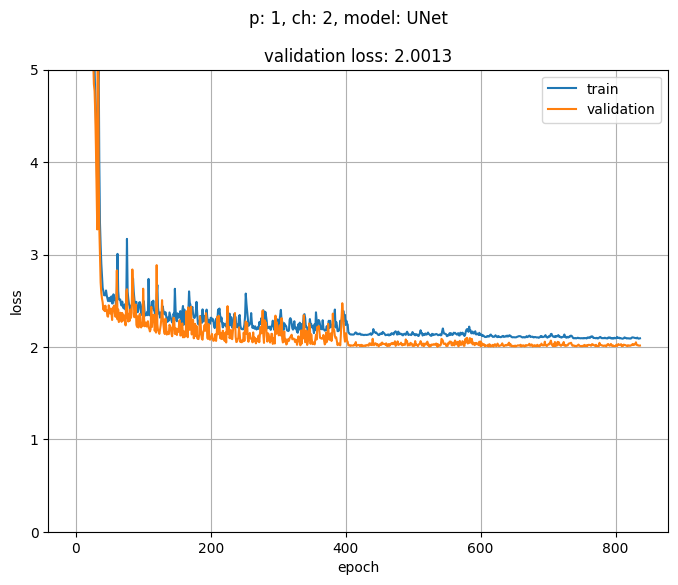

1/1 [==============================] - 5s 5s/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


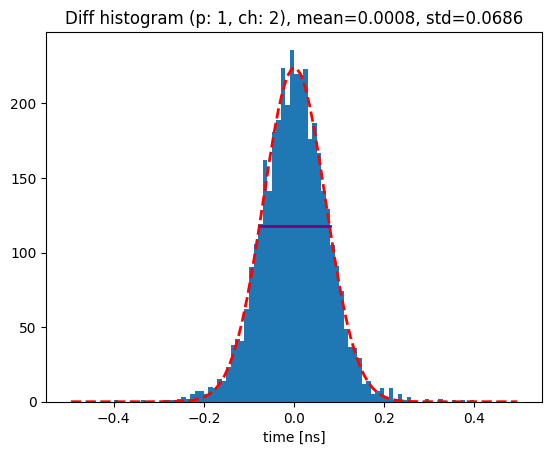

       CFD: 75.42 ps
      UNet: 68.63 ps (improvement: 9.00 %)


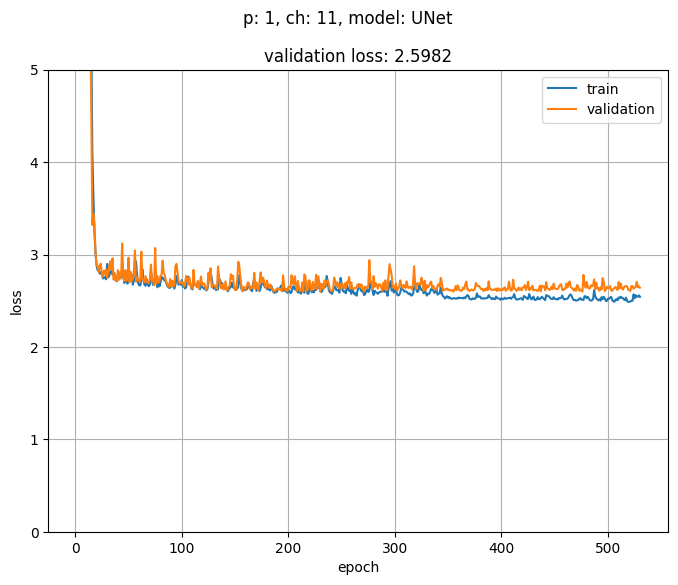

2/2 [==============================] - 1s 82ms/step


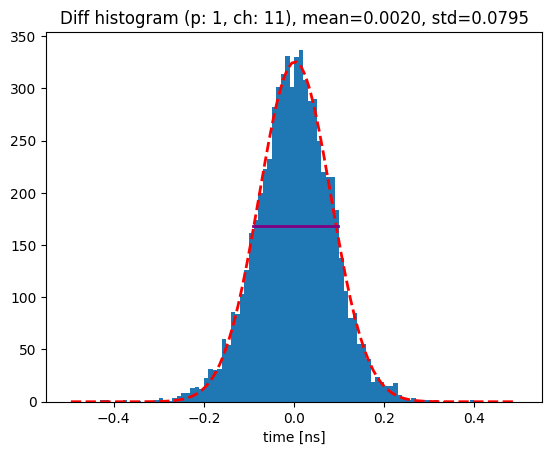

       CFD: 87.28 ps
      UNet: 79.46 ps (improvement: 8.96 %)


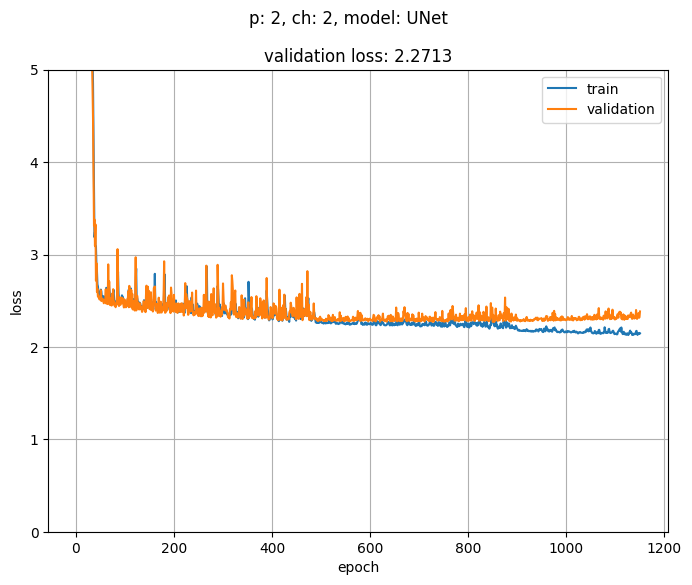

1/1 [==============================] - 1s 583ms/step


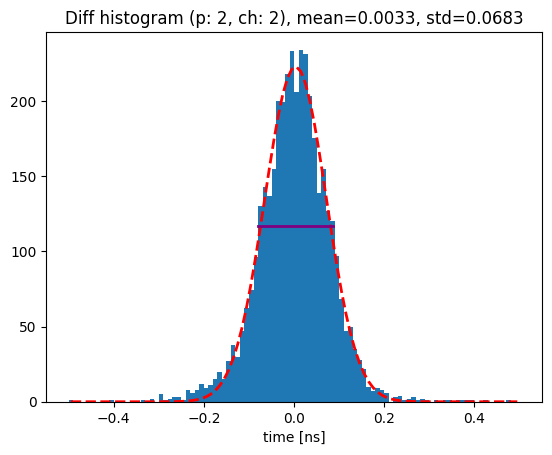

       CFD: 78.14 ps
      UNet: 68.33 ps (improvement: 12.56 %)


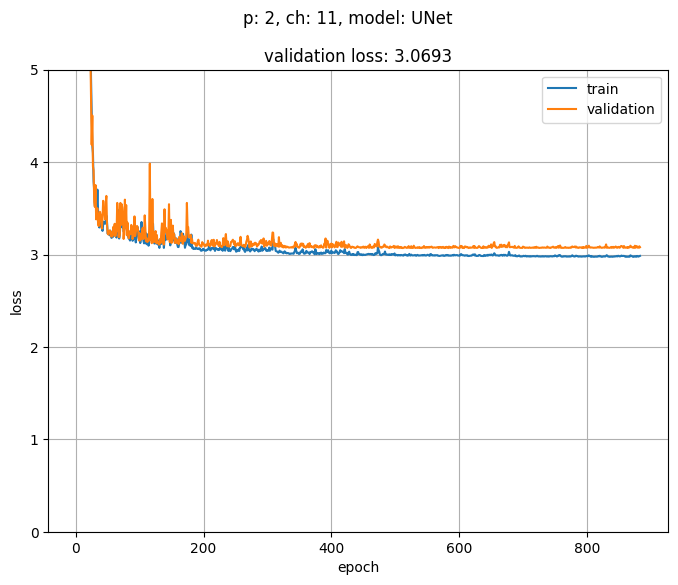

2/2 [==============================] - 1s 273ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


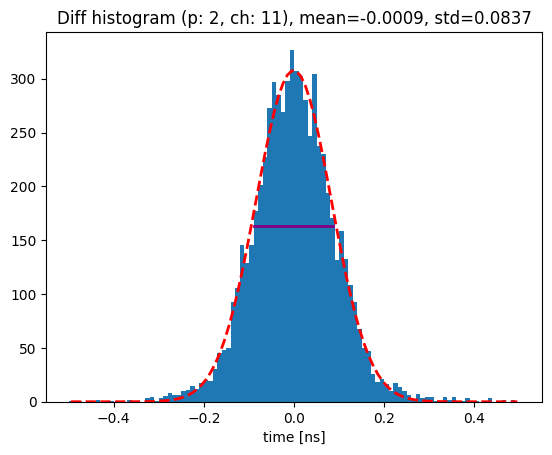

       CFD: 89.47 ps
      UNet: 83.65 ps (improvement: 6.50 %)


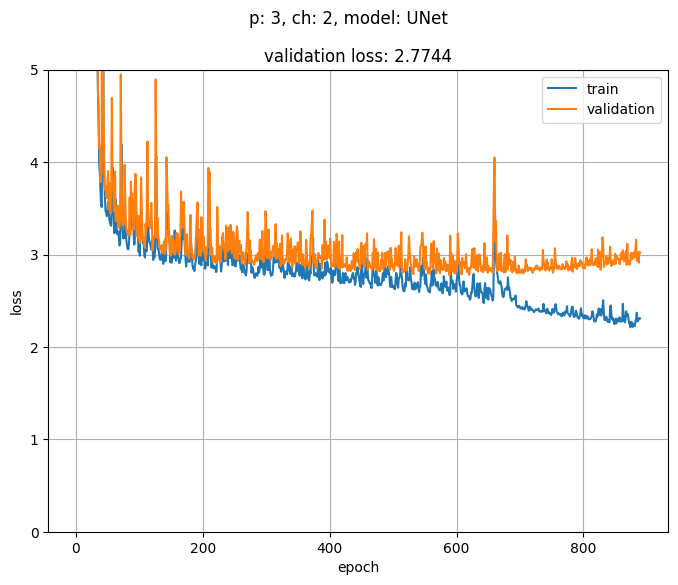

1/1 [==============================] - 1s 593ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


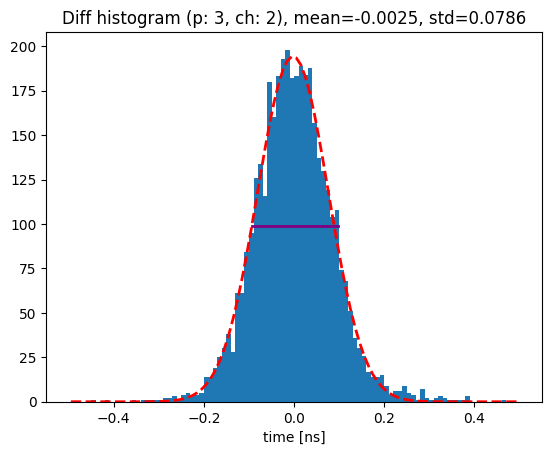

       CFD: 87.37 ps
      UNet: 78.63 ps (improvement: 10.00 %)


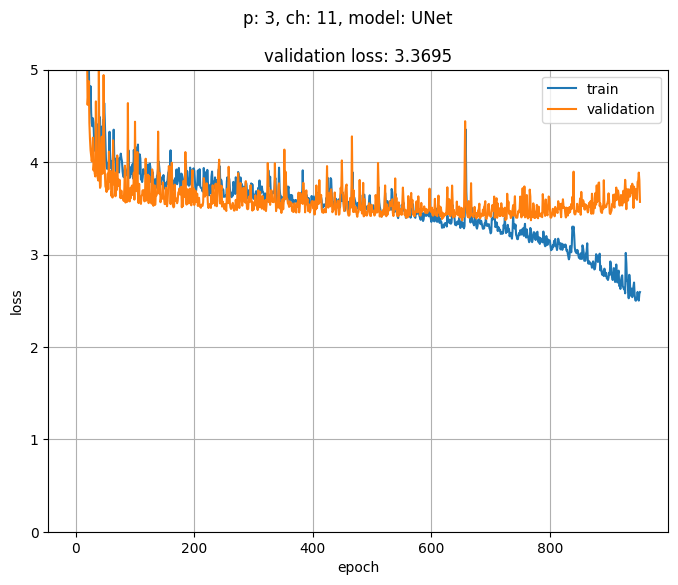

2/2 [==============================] - 0s 227ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


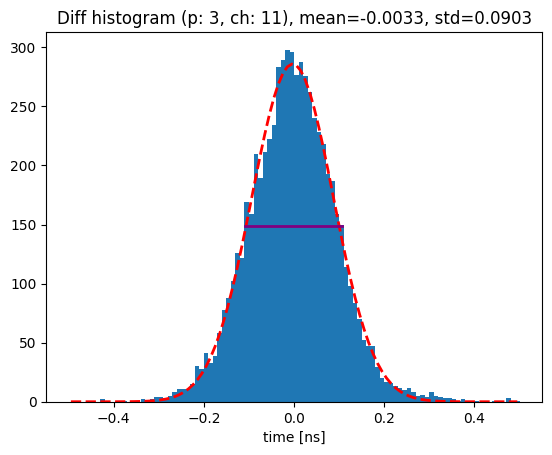

       CFD: 112.05 ps
      UNet: 90.33 ps (improvement: 19.39 %)


In [10]:
improvements = {}
for plane, channel in sorted(dataset.keys()):
    display(HTML(f'<h3>Plane: {plane}, channel: {channel}</h3>'))

    all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.25,
                                                        random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    # CFD
    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(x_time, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, plane=plane, channel=channel, show=False)

    # Network
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    model = create_model()
    try:
        history = train_model(model, f'{model_name}_{plane}_{channel}', X_train=X_train, y_train=Y_heatmap_train,
                              X_val=X_test, y_val=Y_heatmap_test, train=False)
    except (FileNotFoundError, NotFoundError):
        print(f'Could not find the model for ({plane}, {channel}). Setting train=False')
        history = train_model(model, f'{model_name}_{plane}_{channel}', X_train=X_train, y_train=Y_heatmap_train,
                              X_val=X_test, y_val=Y_heatmap_test, train=False)

    plot_history(history, f'p: {plane}, ch: {channel}, model: {model_name}', ymax=5)

    y_pred_model = model_predict(model, X_test)

    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, plane=plane, channel=channel, show=True)

    print('=====================================================================')
    compare_results([std_model], [model_name], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [11]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  75.42 ps, NN:  68.63 ( 9.00 %)
(1, 11) CFD:  87.28 ps, NN:  79.46 ( 8.96 %)
(2,  2) CFD:  78.14 ps, NN:  68.33 (12.56 %)
(2, 11) CFD:  89.47 ps, NN:  83.65 ( 6.50 %)
(3,  2) CFD:  87.37 ps, NN:  78.63 (10.00 %)
(3, 11) CFD: 112.05 ps, NN:  90.33 (19.39 %)
